### Find Regimes 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training GMM model on data from 1995-01-01 to 2025-01-01
Training data shape: (7489, 42)

Regime Characteristics Summary:
Regime   Label    Count    Return %   Vol      VIX      BB Width   ATR %    Chop Idx TNX %    TNX Chg 
----------------------------------------------------------------------------------------------------
0        Bull     3481     0.31       15.19    17.86    6.47       1.27     49.21    3.63     1.12    
1        Bear     1447     -0.42      26.40    29.63    11.07      2.40     42.28    3.68     -4.85   
2        Neutral  2561     -0.06      12.22    17.47    4.70       1.14     50.49    3.82     0.72    

Regime Scoring Details:
Regime   Label    Bull Score Bear Score Neutral Score
------------------------------------------------------------
0        Bull     4          0          3           
1        Bear     0          6          1           
2        Neutral  2          2          7           

Model Evaluation:
BIC: 240036.05 (lower is better)
AIC: 239482.36

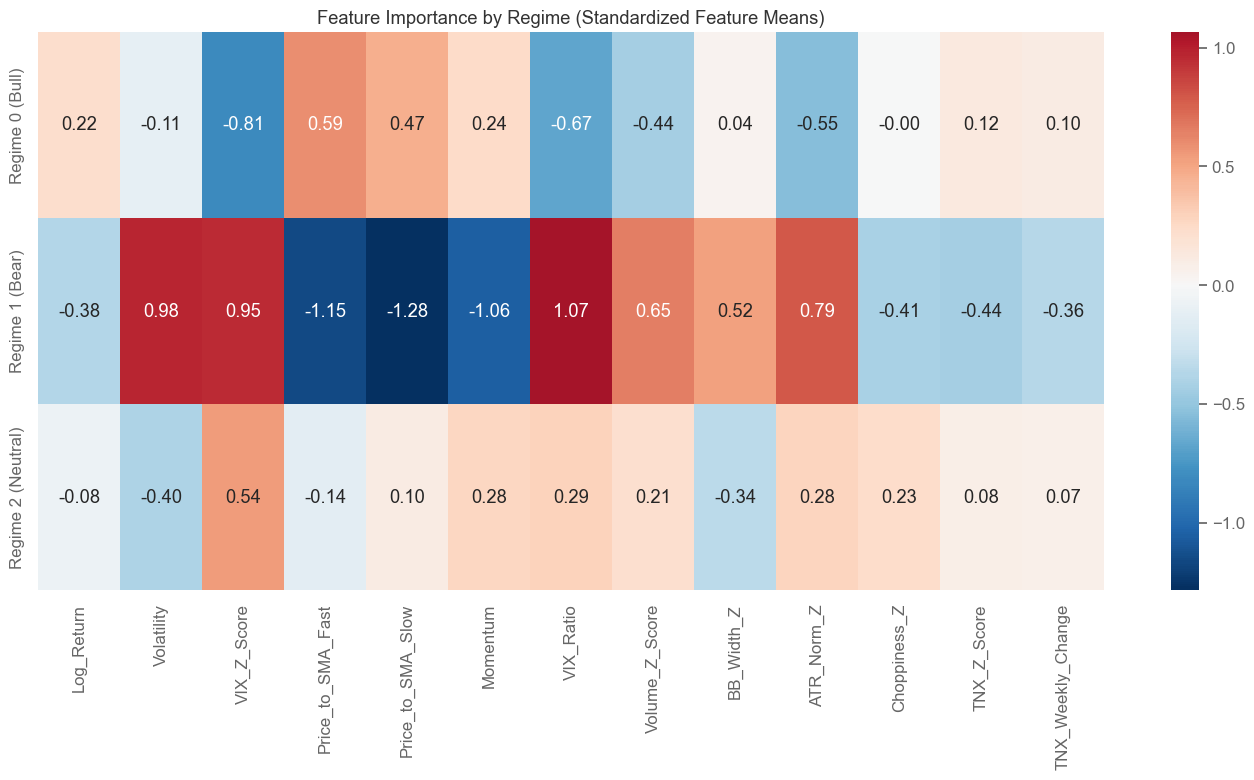

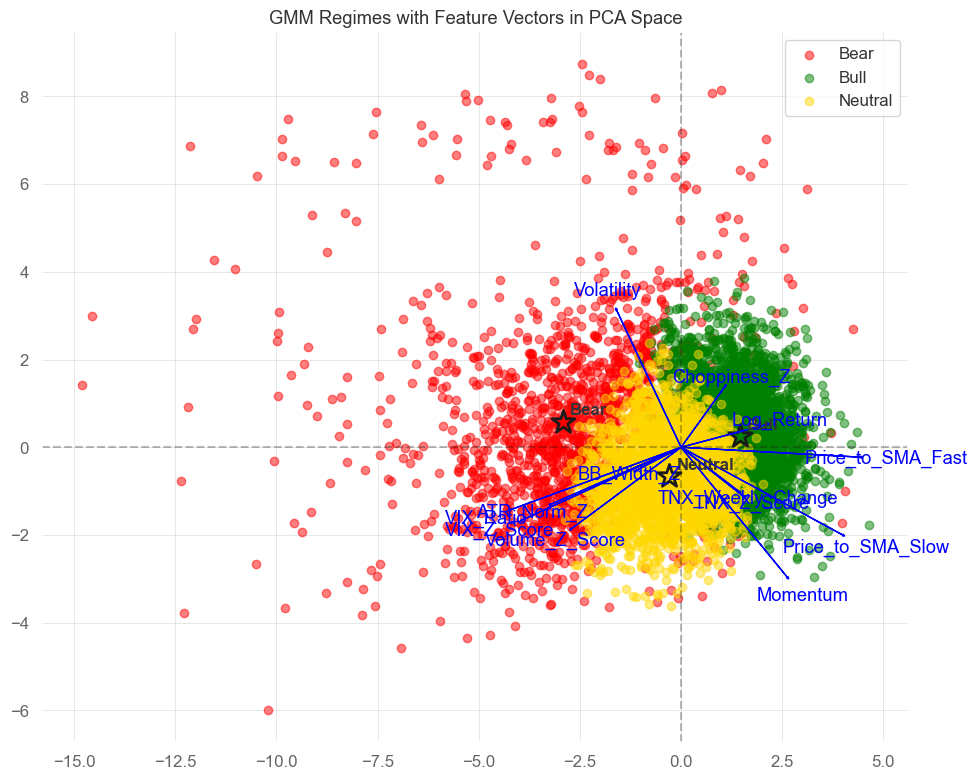


Predicting regimes for recent period (2025-01-02 to 2025-04-19):
Predicted regimes for period 2025-01-02 to 2025-04-19

Regime Distribution:
Regime 0 [Bull]: 30.14%
Regime 1 [Bear]: 39.73%
Regime 2 [Neutral]: 30.14%

Regime persistence: 4.56 days average duration



Analyzing recent period with probability smoothing (2024-01-01 to 2025-04-14):

Smoothed Regime Prediction (window=14) from 2025-01-02 to 2025-04-19

Regime Distribution (smoothed):
Regime 0 [Bull]: 30.14%
Regime 1 [Bear]: 52.05%
Regime 2 [Neutral]: 17.81%

Regime persistence (smoothed): 12.17 days average duration
Regime persistence (raw): 4.56 days average duration
Smoothing reduced regime changes by 62.5%


In [36]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ======== CONFIGURABLE PARAMETERS ========
# Market data parameters
TICKER = 'SPY'  # Main ticker to analyze
VIX_TICKER = '^VIX'  # Volatility index
TNX_TICKER = '^TNX'  # 10-Year Treasury Yield
START_DATE = "1995-01-01"  # Historical data start date

# GMM model parameters  
NUM_REGIMES = 3  # Number of market regimes
MAX_ITERATIONS = 1000  # Max iterations for GMM convergence
N_INIT = 100  # Number of initializations
COVARIANCE_TYPE = 'diag'  # Options: 'full', 'tied', 'diag', 'spherical'

# Technical indicator parameters
VOL_WINDOW = 21  # Window for volatility calculation (21 days ~ 1 month)
MOMENTUM_WINDOW = 63  # Window for momentum calculation (63 days ~ 3 months)
SMA_FAST = 20  # Fast moving average
SMA_SLOW = 50  # Slow moving average
BB_WINDOW = 20  # Bollinger Bands window
BB_STD = 2  # Bollinger Bands standard deviation multiplier
ATR_WINDOW = 14  # Average True Range window
CHOP_WINDOW = 14  # Choppiness Index window

# Training period
TRAIN_START_DATE = "1995-01-01"
TRAIN_END_DATE = "2025-01-01"

# ======== DATA PREPARATION FUNCTIONS ========
def download_market_data(ticker, vix_ticker, tnx_ticker, start_date):
    """Download and prepare market data"""
    end_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
    print(f"Downloading market data from {start_date} to {end_date}...")
    
    # Download ticker, VIX, and TNX data
    df_ticker = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    df_vix = yf.download(vix_ticker, start=start_date, end=end_date)
    df_tnx = yf.download(tnx_ticker, start=start_date, end=end_date)
    
    # Fix column structure and reset index
    if len(df_ticker.columns.names) > 1:
        df_ticker.columns = df_ticker.columns.droplevel(1)
    if len(df_vix.columns.names) > 1:
        df_vix.columns = df_vix.columns.droplevel(1)
    if len(df_tnx.columns.names) > 1:
        df_tnx.columns = df_tnx.columns.droplevel(1)
    
    df_ticker = df_ticker.reset_index()
    df_vix = df_vix.reset_index()
    df_tnx = df_tnx.reset_index()
    
    # Keep only Date and Close from VIX
    df_vix = df_vix[['Date', 'Close']].rename(columns={'Close': 'VIX'})
    
    # Keep only Date and Close from TNX
    df_tnx = df_tnx[['Date', 'Close']].rename(columns={'Close': 'TNX'})
    
    # Merge data
    df = pd.merge(df_ticker, df_vix, on='Date', how='left')
    df = pd.merge(df, df_tnx, on='Date', how='left')
    
    # Fill missing values with forward fill method
    df['VIX'] = df['VIX'].fillna(method='ffill')
    df['TNX'] = df['TNX'].fillna(method='ffill')
    
    df['LogVIX'] = np.log(df['VIX'])
    
    # Calculate daily log returns
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    
    return df

def calculate_bollinger_bands(df, window=20, num_std=2):
    """Calculate Bollinger Bands and related metrics"""
    # Calculate Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = df['BB_Middle'] + (rolling_std * num_std)
    df['BB_Lower'] = df['BB_Middle'] - (rolling_std * num_std)
    
    # Calculate Bollinger Band Width (normalized)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle'] * 100
    
    # Calculate %B (position within the bands)
    df['BB_PercentB'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    return df

def calculate_atr(df, window=14):
    """Calculate Average True Range (ATR)"""
    # Calculate True Range
    df['TR1'] = abs(df['High'] - df['Low'])
    df['TR2'] = abs(df['High'] - df['Close'].shift(1))
    df['TR3'] = abs(df['Low'] - df['Close'].shift(1))
    df['True_Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)
    
    # Calculate ATR using Wilder's smoothing method
    df['ATR'] = df['True_Range'].rolling(window=window).mean()
    
    # Normalize ATR by price
    df['ATR_Normalized'] = df['ATR'] / df['Close'] * 100
    
    # Clean up intermediate columns
    df = df.drop(['TR1', 'TR2', 'TR3'], axis=1)
    
    return df

def calculate_choppiness_index(df, window=14):
    """
    Calculate Choppiness Index
    
    CI = 100 * LOG10(SUM(ATR, n) / (MaxHi - MinLo)) / LOG10(n)
    Where:
    - n is the window period
    - MaxHi is the highest high in the period
    - MinLo is the lowest low in the period
    - SUM(ATR, n) is the sum of the ATR over the period
    
    Higher values (> 61.8) indicate a choppy market
    Lower values (< 38.2) indicate a trending market
    """
    if 'ATR' not in df.columns:
        df = calculate_atr(df, window)
    
    df['MaxHi'] = df['High'].rolling(window=window).max()
    df['MinLo'] = df['Low'].rolling(window=window).min()
    df['ATR_Sum'] = df['ATR'].rolling(window=window).sum()
    
    # Calculate Choppiness Index
    df['Choppiness_Index'] = 100 * np.log10(df['ATR_Sum'] / (df['MaxHi'] - df['MinLo'])) / np.log10(window)
    
    # Clean up intermediate columns
    df = df.drop(['MaxHi', 'MinLo', 'ATR_Sum'], axis=1)
    
    return df

def calculate_features(data):
    """Calculate features for regime classification"""
    df = data.copy()
    
    # Volatility features
    df['Volatility'] = df['Log_Return'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)  # Annualized
    df['Volume_Z_Score'] = (df['Volume'] - df['Volume'].rolling(window=VOL_WINDOW).mean()) / df['Volume'].rolling(window=VOL_WINDOW).std()
    df['VIX_Z_Score'] = (df['VIX'] - df['VIX'].rolling(window=VOL_WINDOW).mean()) / df['VIX'].rolling(window=VOL_WINDOW).std()
    
    # Trend features
    df['Momentum'] = df['Close'].pct_change(periods=MOMENTUM_WINDOW) * 100
    df['SMA_Fast'] = df['Close'].rolling(window=SMA_FAST).mean()
    df['SMA_Slow'] = df['Close'].rolling(window=SMA_SLOW).mean()
    df['SMA_Ratio'] = df['SMA_Fast'] / df['SMA_Slow']
    
    # Price distance from moving averages
    df['Price_to_SMA_Fast'] = df['Close'] / df['SMA_Fast'] - 1
    df['Price_to_SMA_Slow'] = df['Close'] / df['SMA_Slow'] - 1
    
    # VIX-based features
    df['VIX_Ratio'] = df['VIX'] / df['VIX'].rolling(window=VOL_WINDOW).mean()
    df['VIX_Change'] = df['VIX'].pct_change(periods=5) * 100  # 5-day VIX change
    
    # Treasury Yield (TNX) features
    df['TNX_Level'] = df['TNX']  # Absolute yield level
    df['TNX_Daily_Change'] = df['TNX'].diff() * 100  # Daily change in basis points
    df['TNX_Weekly_Change'] = df['TNX'].diff(5) * 100  # 1-week change in basis points
    df['TNX_Z_Score'] = (df['TNX'] - df['TNX'].rolling(window=VOL_WINDOW).mean()) / df['TNX'].rolling(window=VOL_WINDOW).std()
    df['TNX_Ratio'] = df['TNX'] / df['TNX'].rolling(window=VOL_WINDOW).mean()
    
    # Volume features
    df['Volume_Trend'] = df['Volume'] / df['Volume'].rolling(window=VOL_WINDOW).mean()
    df['Volume_to_Volatility'] = df['Volume'] / (df['Volatility'] + 1e-10)
    
    # Combined features
    df['Return_Volatility_Ratio'] = df['Log_Return'] / (df['Volatility'] + 1e-10)
    df['VIX_Volatility_Ratio'] = df['VIX'] / (df['Volatility'] + 1e-10)
    
    # Add Bollinger Bands features
    df = calculate_bollinger_bands(df, window=BB_WINDOW, num_std=BB_STD)
    
    # Add ATR features
    df = calculate_atr(df, window=ATR_WINDOW)
    
    # Add Choppiness Index
    df = calculate_choppiness_index(df, window=CHOP_WINDOW)
    
    # Calculate Z-scores for the new indicators to help with comparison
    df['BB_Width_Z'] = (df['BB_Width'] - df['BB_Width'].rolling(window=VOL_WINDOW).mean()) / df['BB_Width'].rolling(window=VOL_WINDOW).std()
    df['ATR_Norm_Z'] = (df['ATR_Normalized'] - df['ATR_Normalized'].rolling(window=VOL_WINDOW).mean()) / df['ATR_Normalized'].rolling(window=VOL_WINDOW).std()
    df['Choppiness_Z'] = (df['Choppiness_Index'] - df['Choppiness_Index'].rolling(window=VOL_WINDOW).mean()) / df['Choppiness_Index'].rolling(window=VOL_WINDOW).std()
    
    # Fill NaN values 
    df = df.dropna().reset_index(drop=True)
    
    return df

# ======== GMM MODEL FUNCTIONS ========
def train_gmm_model(data, start_date, end_date, n_components=3, max_iter=500, n_init=10, cov_type='full'):
    """Train GMM model on selected features"""
    # Filter data to training period
    training = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    print(f"Training GMM model on data from {start_date} to {end_date}")
    print(f"Training data shape: {training.shape}")
    
    # Select features for GMM
    features = [
        'Log_Return',             # Daily returns
        'Volatility',             # Recent volatility
        'VIX_Z_Score',            # VIX relative to its recent history
        'Price_to_SMA_Fast',      # Short-term trend
        'Price_to_SMA_Slow',      # Long-term trend
        'Momentum',               # Medium-term price momentum
        'VIX_Ratio',              # VIX relative to its recent average
        'Volume_Z_Score',         # Volume relative to its recent history
        'BB_Width_Z',             # Normalized Bollinger Band width (consolidation)
        'ATR_Norm_Z',             # Normalized ATR (relative volatility)
        'Choppiness_Z',           # Market choppiness/trendiness
        'TNX_Z_Score',            # 10-Year yield relative to recent history
        'TNX_Weekly_Change'       # Weekly change in yields
    ]
    
    feature_data = training[features].values
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_data)
    
    # Create and train the model
    model = GaussianMixture(
        n_components=n_components, 
        covariance_type=cov_type,
        max_iter=max_iter,
        n_init=n_init,
        random_state=42
    )
    model.fit(scaled_features)
    
    # Get regime predictions and probabilities for training data
    predictions = model.predict(scaled_features)
    probabilities = model.predict_proba(scaled_features)
    
    # Analyze regime characteristics
    regime_stats = {}
    for i in range(n_components):
        regime_mask = (predictions == i)
        if np.sum(regime_mask) > 0:
            regime_stats[i] = {
                'count': np.sum(regime_mask),
                'return_avg': np.mean(training.loc[regime_mask, 'Log_Return']),
                'return_std': np.std(training.loc[regime_mask, 'Log_Return']),
                'volatility_avg': np.mean(training.loc[regime_mask, 'Volatility']),
                'vix_avg': np.mean(training.loc[regime_mask, 'VIX']),
                'vix_ratio_avg': np.mean(training.loc[regime_mask, 'VIX_Ratio']),
                'momentum_avg': np.mean(training.loc[regime_mask, 'Momentum']),
                'volume_zscore_avg': np.mean(training.loc[regime_mask, 'Volume_Z_Score']),
                'bb_width_avg': np.mean(training.loc[regime_mask, 'BB_Width']),
                'atr_norm_avg': np.mean(training.loc[regime_mask, 'ATR_Normalized']),
                'choppiness_avg': np.mean(training.loc[regime_mask, 'Choppiness_Index']),
                'tnx_avg': np.mean(training.loc[regime_mask, 'TNX']),
                'tnx_zscore_avg': np.mean(training.loc[regime_mask, 'TNX_Z_Score']),
                'tnx_weekly_change_avg': np.mean(training.loc[regime_mask, 'TNX_Weekly_Change']),
                'prob_avg': np.mean(probabilities[:, i])
            }
    
    # Assign labels to regimes based on characteristics
    regime_labels = [""] * n_components
    bull_scores = []
    bear_scores = []
    neutral_scores = []
    
    for i in range(n_components):
        if i not in regime_stats:
            bull_scores.append(0)
            bear_scores.append(0)
            neutral_scores.append(0)
            continue
            
        stats = regime_stats[i]
        
        # Bull regime scoring: high returns, positive momentum, lower VIX
        bull_score = 0
        if stats['return_avg'] > 0.05:
            bull_score += 2
        elif stats['return_avg'] > 0:
            bull_score += 1
        
        if stats['momentum_avg'] > 5:
            bull_score += 2
        elif stats['momentum_avg'] > 0:
            bull_score += 1
            
        if stats['vix_ratio_avg'] < 0.9:
            bull_score += 2
        elif stats['vix_ratio_avg'] < 1:
            bull_score += 1
            
        # Add trend strength scoring (lower values indicate strong trend)
        if stats['choppiness_avg'] < 38.2:
            bull_score += 1
        
        # Bear regime scoring: negative returns, negative momentum, higher VIX
        bear_score = 0
        if stats['return_avg'] < -0.1:
            bear_score += 2
        elif stats['return_avg'] < 0:
            bear_score += 1
        
        if stats['momentum_avg'] < -5:
            bear_score += 2
        elif stats['momentum_avg'] < 0:
            bear_score += 1
            
        if stats['vix_ratio_avg'] > 1.2:
            bear_score += 2
        elif stats['vix_ratio_avg'] > 1:
            bear_score += 1
            
        # Higher ATR often indicates bear markets (more volatile)
        if stats['atr_norm_avg'] > np.mean([s['atr_norm_avg'] for s in regime_stats.values()]) * 1.2:
            bear_score += 1
            
        # Add trend strength scoring (lower values indicate strong trend)
        if stats['choppiness_avg'] < 38.2:
            bear_score += 1
            
        # Add Treasury yield scoring (rising yields often coincide with bear markets)
        if stats['tnx_weekly_change_avg'] > 10:  # 10 basis points per week is significant
            bear_score += 1
        
        # Neutral regime scoring: modest returns, low volatility, normal VIX, choppy markets
        neutral_score = 0
        if abs(stats['return_avg']) < 0.05:
            neutral_score += 2
        elif abs(stats['return_avg']) < 0.1:
            neutral_score += 1
        
        if abs(stats['momentum_avg']) < 3:
            neutral_score += 2
        elif abs(stats['momentum_avg']) < 5:
            neutral_score += 1
            
        if 0.95 <= stats['vix_ratio_avg'] <= 1.05:
            neutral_score += 2
        elif 0.9 <= stats['vix_ratio_avg'] <= 1.1:
            neutral_score += 1
            
        # Narrow Bollinger Bands often indicate consolidation (neutral)
        if stats['bb_width_avg'] < np.mean([s['bb_width_avg'] for s in regime_stats.values()]) * 0.8:
            neutral_score += 2
            
        # High Choppiness Index indicates consolidation (neutral)
        if stats['choppiness_avg'] > 61.8:  # Traditional threshold
            neutral_score += 2
        elif stats['choppiness_avg'] > 50:
            neutral_score += 1
        
        # Add Treasury yield scoring (stable yields often coincide with neutral markets)
        if abs(stats['tnx_weekly_change_avg']) < 5:  # Small weekly changes
            neutral_score += 1
        
        bull_scores.append(bull_score)
        bear_scores.append(bear_score)
        neutral_scores.append(neutral_score)
    
    # Assign labels based on highest score
    labels_to_assign = ["Bull", "Bear", "Neutral"]
    scores = [(i, max(bull_scores[i], bear_scores[i], neutral_scores[i]), 
               "Bull" if bull_scores[i] >= max(bear_scores[i], neutral_scores[i]) else
               "Bear" if bear_scores[i] >= max(bull_scores[i], neutral_scores[i]) else
               "Neutral") 
              for i in range(n_components)]
    
    # Sort by score and assign labels ensuring each label is used only once
    scores.sort(key=lambda x: x[1], reverse=True)
    assigned_labels = set()
    
    for regime_idx, _, preferred_label in scores:
        if preferred_label not in assigned_labels:
            regime_labels[regime_idx] = preferred_label
            assigned_labels.add(preferred_label)
        else:
            # Find an unassigned label
            for label in labels_to_assign:
                if label not in assigned_labels:
                    regime_labels[regime_idx] = label
                    assigned_labels.add(label)
                    break
    
    # Print key regime statistics
    print("\nRegime Characteristics Summary:")
    print("=" * 100)
    print(f"{'Regime':<8} {'Label':<8} {'Count':<8} {'Return %':<10} {'Vol':<8} {'VIX':<8} {'BB Width':<10} {'ATR %':<8} {'Chop Idx':<8} {'TNX %':<8} {'TNX Chg':<8}")
    print("-" * 100)
    
    for i in range(n_components):
        if i in regime_stats:
            stats = regime_stats[i]
            print(f"{i:<8} {regime_labels[i]:<8} {stats['count']:<8} "
                  f"{stats['return_avg']:<10.2f} {stats['volatility_avg']:<8.2f} {stats['vix_avg']:<8.2f} "
                  f"{stats['bb_width_avg']:<10.2f} {stats['atr_norm_avg']:<8.2f} {stats['choppiness_avg']:<8.2f} "
                  f"{stats['tnx_avg']:<8.2f} {stats['tnx_weekly_change_avg']:<8.2f}")
    
    # Print scoring details
    print("\nRegime Scoring Details:")
    print("=" * 60)
    print(f"{'Regime':<8} {'Label':<8} {'Bull Score':<10} {'Bear Score':<10} {'Neutral Score':<12}")
    print("-" * 60)
    
    for i in range(n_components):
        print(f"{i:<8} {regime_labels[i]:<8} {bull_scores[i]:<10} {bear_scores[i]:<10} {neutral_scores[i]:<12}")
    
    # Calculate BIC and AIC for model evaluation
    print(f"\nModel Evaluation:")
    print(f"BIC: {model.bic(scaled_features):.2f} (lower is better)")
    print(f"AIC: {model.aic(scaled_features):.2f} (lower is better)")
    
    # Calculate average regime duration and transitions
    training['Regime'] = predictions
    training['Regime_Probability'] = np.max(probabilities, axis=1)
    
    # Calculate regime transitions
    regime_changes = (training['Regime'] != training['Regime'].shift(1)).sum()
    avg_duration = len(training) / (regime_changes if regime_changes > 0 else 1)
    print(f"\nRegime persistence: {avg_duration:.2f} days average duration")
    
    # Calculate regime distribution
    regime_counts = pd.Series(predictions).value_counts(normalize=True) * 100
    print("\nRegime Distribution:")
    for regime, percentage in sorted(regime_counts.items()):
        print(f"Regime {regime} [{regime_labels[regime]}]: {percentage:.2f}%")
    
    # Find transition probability matrix
    transitions = np.zeros((n_components, n_components))
    for i in range(1, len(training)):
        prev_regime = training['Regime'].iloc[i-1]
        curr_regime = training['Regime'].iloc[i]
        transitions[prev_regime, curr_regime] += 1
    
    # Convert transitions to percentages
    for i in range(n_components):
        row_sum = transitions[i, :].sum()
        if row_sum > 0:
            transitions[i, :] = transitions[i, :] / row_sum * 100
    
    # Print transition matrix
    print("\nRegime Transition Matrix:")    
    print("=" * 60)
    print(f"{'From/To':<10}", end="")
    for i in range(n_components):
        print(f"{regime_labels[i]:<10}", end="")
    print()
    print("-" * 60)
    
    for i in range(n_components):
        print(f"{regime_labels[i]:<10}", end="")
        for j in range(n_components):
            print(f"{transitions[i, j]:<10.2f}", end="")
        print()
    
    # Bundle model, scaler and other info
    model_bundle = {
        'model': model,
        'scaler': scaler,
        'features': features,
        'regime_labels': regime_labels
    }
    
    return model_bundle, training, predictions, regime_labels, regime_stats

def predict_regimes(model_bundle, data, start_date, end_date):
    """Predict market regimes for a specific date range using the trained GMM model"""
    # Extract model components
    model = model_bundle['model']
    scaler = model_bundle['scaler']
    features = model_bundle['features']
    regime_labels = model_bundle['regime_labels']
    
    # Filter data for prediction period
    pred_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    if len(pred_data) == 0:
        print(f"No data available for period {start_date} to {end_date}")
        return None
    
    # Prepare features for prediction
    feature_data = pred_data[features].values
    
    # Scale features using the same scaler as training
    scaled_features = scaler.transform(feature_data)
    
    # Predict regimes and probabilities
    predictions = model.predict(scaled_features)
    probabilities = model.predict_proba(scaled_features)
    
    # Add predictions to dataframe
    pred_data['Predicted_Regime'] = predictions
    pred_data['Regime_Label'] = [regime_labels[r] for r in predictions]
    pred_data['Regime_Probability'] = np.max(probabilities, axis=1)
    
    # Add probability columns for each regime
    for i, label in enumerate(regime_labels):
        pred_data[f'Prob_{label}'] = probabilities[:, i]
    
    # Print basic statistics about the prediction
    print(f"Predicted regimes for period {start_date} to {end_date}")
    
    # Calculate regime distribution
    regime_counts = pd.Series(predictions).value_counts(normalize=True) * 100
    print("\nRegime Distribution:")
    for regime, percentage in sorted(regime_counts.items()):
        print(f"Regime {regime} [{regime_labels[regime]}]: {percentage:.2f}%")
    
    # Calculate average regime duration
    regime_changes = (pred_data['Predicted_Regime'] != pred_data['Predicted_Regime'].shift(1)).sum()
    avg_duration = len(pred_data) / (regime_changes if regime_changes > 0 else 1)
    print(f"\nRegime persistence: {avg_duration:.2f} days average duration")
    
    return pred_data

# ======== VISUALIZATION FUNCTIONS ========
def plot_regimes(results, title=None):
    """Plot SPY price with regime classifications"""
    if results is None or len(results) == 0:
        print("No data available to plot")
        return
    
    # Set plot title
    if title is None:
        start_date = results['Date'].min().strftime('%Y-%m-%d')
        end_date = results['Date'].max().strftime('%Y-%m-%d')
        title = f'Market Regimes from {start_date} to {end_date}'
    
    # Create a categorical color map for regimes
    unique_regimes = results['Predicted_Regime'].unique()
    n_regimes = len(unique_regimes)
    
    # Define specific colors for each regime type
    color_map = {
        'Bull': 'green',
        'Bear': 'red',
        'Neutral': 'gold'
    }
    
    # Create figure with two subplots
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        row_heights=[0.7, 0.3],
                        subplot_titles=(title, "Regime Probabilities"))
    
    # Add price line
    fig.add_trace(
        go.Scatter(
            x=results['Date'],
            y=results['Close'],
            mode='lines',
            line=dict(color='rgba(0,0,0,0.3)', width=1),
            name=f'{TICKER} Price'
        ),
        row=1, col=1
    )
    
    # Add colored markers for different regimes
    for i, regime in enumerate(sorted(unique_regimes)):
        regime_data = results[results['Predicted_Regime'] == regime]
        regime_label = results.loc[results['Predicted_Regime'] == regime, 'Regime_Label'].iloc[0]
        
        # Use our predefined colors based on regime label
        color = color_map.get(regime_label, px.colors.qualitative.Set2[i])
        
        fig.add_trace(
            go.Scatter(
                x=regime_data['Date'], 
                y=regime_data['Close'],
                mode='markers',
                marker=dict(color=color, size=6),
                name=f'{regime_label} Regime',
                hovertemplate='%{x}<br>Price: %{y:.2f}<br>Regime: ' + regime_label + 
                              '<br>Probability: %{text:.2f}',
                text=regime_data['Regime_Probability']
            ),
            row=1, col=1
        )
    
    # Add regime probability traces in the second subplot
    regime_labels = [col.replace('Prob_', '') for col in results.columns if col.startswith('Prob_')]
    for label in regime_labels:
        color = color_map.get(label, 'gray')
        fig.add_trace(
            go.Scatter(
                x=results['Date'],
                y=results[f'Prob_{label}'],
                mode='lines',
                line=dict(width=2, color=color),
                name=f'{label} Probability'
            ),
            row=2, col=1
        )
    
    # Add a horizontal line at 0.5 probability
    fig.add_shape(
        type="line",
        x0=results['Date'].min(),
        y0=0.5,
        x1=results['Date'].max(),
        y1=0.5,
        line=dict(color="black", width=1, dash="dash"),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        xaxis_title='Date',
        yaxis_title=f'{TICKER} Price',
        yaxis2_title='Probability',
        template='plotly_white',
        legend_title='Market Regimes',
        hovermode='closest',
        height=800
    )
    
    # Set y-axis range for probability subplot
    fig.update_yaxes(range=[0, 1], row=2, col=1)
    
    fig.show()
    
    # Create pie chart showing regime distribution
    regime_distribution = results['Regime_Label'].value_counts().reset_index()
    regime_distribution.columns = ['Regime', 'Days']
    regime_distribution['Percentage'] = regime_distribution['Days'] / len(results) * 100
    
    # Use the same colors for pie chart
    pie_colors = [color_map.get(label, 'gray') for label in regime_distribution['Regime']]
    
    fig_pie = px.pie(
        regime_distribution, 
        values='Percentage', 
        names='Regime',
        title=f'Regime Distribution ({results["Date"].min().strftime("%Y-%m-%d")} to {results["Date"].max().strftime("%Y-%m-%d")})',
        color='Regime',
        color_discrete_map={label: color_map.get(label, 'gray') for label in regime_distribution['Regime']}
    )
    
    fig_pie.update_traces(textinfo='percent+label', textposition='inside')
    fig_pie.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
    
    fig_pie.show()

def plot_feature_importance(model_bundle, training_data):
    """
    Plot feature importance for the GMM model based on component means and weights
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        model = model_bundle['model']
        features = model_bundle['features']
        regime_labels = model_bundle['regime_labels']
        
        # Get means and weights from the model
        means = model.means_
        weights = model.weights_
        
        # Plot means for each feature across components
        plt.figure(figsize=(14, 8))
        
        # Create heatmap of means
        sns.heatmap(means, cmap='RdBu_r', center=0, 
                    xticklabels=features, 
                    yticklabels=[f"Regime {i} ({regime_labels[i]})" for i in range(len(regime_labels))],
                    annot=True, fmt=".2f")
        
        plt.title('Feature Importance by Regime (Standardized Feature Means)')
        plt.tight_layout()
        plt.show()
        
        # Plot PCA for feature visualization
        feature_data = training_data[features].values
        scaler = model_bundle['scaler']
        scaled_features = scaler.transform(feature_data)
        
        # Reduce to 2D using PCA
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(scaled_features)
        
        # Get component contributions
        component_loadings = pca.components_.T
        variance_ratio = pca.explained_variance_ratio_
        
        # Create scatter plot of data points colored by regime
        plt.figure(figsize=(10, 8))
        
        predictions = model.predict(scaled_features)
        
        # Create a DataFrame with reduced features and cluster labels
        viz_df = pd.DataFrame({
            'PC1': reduced_features[:, 0],
            'PC2': reduced_features[:, 1],
            'Regime': predictions,
            'Label': [regime_labels[p] for p in predictions]
        })
        
        # Custom colors for regimes
        color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'gold'}
        
        # Plot data points
        for label, group in viz_df.groupby('Label'):
            plt.scatter(group['PC1'], group['PC2'], 
                       label=label, 
                       color=color_map.get(label, 'gray'), 
                       alpha=0.5)
        
        # Plot centroids
        centroids_pca = pca.transform(means)
        for i, (x, y) in enumerate(centroids_pca):
            plt.scatter(x, y, s=300, marker='*', 
                       color=color_map.get(regime_labels[i], 'gray'), 
                       edgecolor='k', linewidth=2)
            plt.annotate(regime_labels[i], (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=12, fontweight='bold')
        
        # Plot feature vectors
        for i, feature in enumerate(features):
            plt.arrow(0, 0, component_loadings[i, 0]*max(abs(reduced_features[:, 0]))*0.7, 
                     component_loadings[i, 1]*max(abs(reduced_features[:, 1]))*0.7, 
                     head_width=0.05, head_length=0.05, fc='blue', ec='blue')
            plt.text(component_loadings[i, 0]*max(abs(reduced_features[:, 0]))*0.8, 
                    component_loadings[i, 1]*max(abs(reduced_features[:, 1]))*0.8, 
                    feature, color='blue', ha='center', va='center')
        
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.title('GMM Regimes with Feature Vectors in PCA Space')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Visualization requires matplotlib and seaborn. Install with: pip install matplotlib seaborn")

# %%
# Additional analysis tools for GMM-based regime detection

def apply_probability_smoothing(probabilities, window_size=5):
    """
    Apply smoothing to regime probabilities rather than discrete labels
    
    Parameters:
    -----------
    probabilities : array-like of shape (n_samples, n_components)
        Probabilities for each sample belonging to each regime
    window_size : int
        Size of the rolling window for smoothing
    
    Returns:
    --------
    array-like of shape (n_samples, n_components)
        Smoothed probabilities
    """
    import pandas as pd
    import numpy as np
    
    # Convert to DataFrame for easy rolling operations
    prob_df = pd.DataFrame(probabilities)
    
    # Apply rolling mean to each probability column
    smoothed_probs = prob_df.rolling(window=window_size, center=True).mean()
    
    # Fill NaN values at edges with original probabilities
    for col in prob_df.columns:
        smoothed_probs[col] = smoothed_probs[col].fillna(prob_df[col])
    
    # Renormalize so probabilities sum to 1
    row_sums = smoothed_probs.sum(axis=1)
    for col in smoothed_probs.columns:
        smoothed_probs[col] = smoothed_probs[col] / row_sums
    
    return smoothed_probs.values

def analyze_with_smoothing(model_bundle, data, start_date, end_date, window_size=5, title=None):
    """
    Analyze a time period with smoothed probabilities to reduce regime-switching noise
    """
    # Extract model components
    model = model_bundle['model']
    scaler = model_bundle['scaler']
    features = model_bundle['features']
    regime_labels = model_bundle['regime_labels']
    
    # Filter data for prediction period
    pred_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    if len(pred_data) == 0:
        print(f"No data available for period {start_date} to {end_date}")
        return None
    
    # Prepare features for prediction
    feature_data = pred_data[features].values
    
    # Scale features using the same scaler as training
    scaled_features = scaler.transform(feature_data)
    
    # Get raw probabilities
    raw_probabilities = model.predict_proba(scaled_features)
    
    # Apply smoothing to the probabilities
    smoothed_probabilities = apply_probability_smoothing(raw_probabilities, window_size)
    
    # Get predictions from smoothed probabilities
    predictions = np.argmax(smoothed_probabilities, axis=1)
    
    # Add predictions to dataframe
    pred_data['Predicted_Regime'] = predictions
    pred_data['Regime_Label'] = [regime_labels[r] for r in predictions]
    pred_data['Regime_Probability'] = np.max(smoothed_probabilities, axis=1)
    
    # Add probability columns
    for i, label in enumerate(regime_labels):
        pred_data[f'Prob_{label}'] = smoothed_probabilities[:, i]
    
    # For comparison, also compute raw predictions
    raw_predictions = model.predict(scaled_features)
    pred_data['Raw_Regime'] = raw_predictions
    
    # Calculate statistics
    print(f"\nSmoothed Regime Prediction (window={window_size}) from {start_date} to {end_date}")
    
    # Calculate regime distribution
    regime_counts = pd.Series(predictions).value_counts(normalize=True) * 100
    print("\nRegime Distribution (smoothed):")
    for regime, percentage in sorted(regime_counts.items()):
        print(f"Regime {regime} [{regime_labels[regime]}]: {percentage:.2f}%")
    
    # Calculate average regime duration
    regime_changes = (pred_data['Predicted_Regime'] != pred_data['Predicted_Regime'].shift(1)).sum()
    avg_duration = len(pred_data) / (regime_changes if regime_changes > 0 else 1)
    print(f"\nRegime persistence (smoothed): {avg_duration:.2f} days average duration")
    
    # Compare with raw predictions
    raw_changes = (pred_data['Raw_Regime'] != pred_data['Raw_Regime'].shift(1)).sum()
    raw_duration = len(pred_data) / (raw_changes if raw_changes > 0 else 1)
    print(f"Regime persistence (raw): {raw_duration:.2f} days average duration")
    print(f"Smoothing reduced regime changes by {(raw_changes - regime_changes) / raw_changes * 100:.1f}%")
    
    # Create a custom title if not provided
    if title is None:
        title = f'Smoothed Market Regimes (window={window_size}) from {start_date} to {end_date}'
    
    # Plot the results
    plot_regimes(pred_data, title)
    
    return pred_data

# ======== MAIN EXECUTION ========
def main():
    # Download and prepare data
    df = download_market_data(TICKER, VIX_TICKER, TNX_TICKER, START_DATE)
    df = calculate_features(df)
    
    # Train model
    model_bundle, training_data, train_predictions, regime_labels, regime_stats = train_gmm_model(
        df, TRAIN_START_DATE, TRAIN_END_DATE, NUM_REGIMES, MAX_ITERATIONS, N_INIT, COVARIANCE_TYPE
    )
    
    # Store regime labels in the model bundle for convenience
    model_bundle['regime_labels'] = regime_labels
    
    # Plot training period results
    training_results = training_data.copy()
    training_results['Predicted_Regime'] = train_predictions
    training_results['Regime_Label'] = [regime_labels[r] for r in train_predictions]
    
    # Add probability columns to training results
    probabilities = model_bundle['model'].predict_proba(
        model_bundle['scaler'].transform(training_data[model_bundle['features']].values)
    )
    training_results['Regime_Probability'] = np.max(probabilities, axis=1)
    for i, label in enumerate(regime_labels):
        training_results[f'Prob_{label}'] = probabilities[:, i]
    
    print("\nVisualization of training period regimes:")
    plot_regimes(training_results, f'Market Regimes - Training Period ({TRAIN_START_DATE} to {TRAIN_END_DATE})')
    
    # Plot feature importance (PCA space visualization)
    try:
        plot_feature_importance(model_bundle, training_data)
    except Exception as e:
        print(f"Could not plot feature importance: {e}")
    
    # Example: Analyze the most recent period
    today = datetime.today()
    recent_start = '2025-01-02'
    recent_end = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
    #recent_end = '2025-02-27'
    
    print(f"\nPredicting regimes for recent period ({recent_start} to {recent_end}):")
    recent_results = predict_regimes(model_bundle, df, recent_start, recent_end)
    plot_regimes(recent_results, f'Market Regimes - Recent Period ({recent_start} to {recent_end})')
    
    # Analyze recent period with probability smoothing
    print(f"\nAnalyzing recent period with probability smoothing (2024-01-01 to 2025-04-14):")
    smoothed_results = analyze_with_smoothing(model_bundle, df, recent_start,recent_end, window_size=14)
    
    return {
        'model_bundle': model_bundle,
        'data': df,
        'training_results': training_results,
        'smoothed_results': smoothed_results  # Now we return the smoothed results
    }

# Function to analyze any time period
def analyze_period(model_objects, start_date, end_date, title=None):
    """Analyze any time period using the trained model"""
    results = predict_regimes(
        model_objects['model_bundle'], 
        model_objects['data'], 
        start_date, 
        end_date
    )
    
    if results is not None:
        plot_regimes(results, title)
    
    return results

# Execute main function
if __name__ == "__main__":
    model_objects = main()

### Strategy Review 

In [37]:
# Strategy Implementation and Evaluation

import pandas as pd
import numpy as np
import yfinance as yf
import quantstats as qs
from datetime import datetime

def implement_regime_strategy(smoothed_results, test_start_date, test_end_date):
    """
    Implement a regime-based trading strategy with proper handling of look-ahead bias.
    
    Strategy allocations by regime:
    - Bull Regime: 50% SPY, 50% Leveraged SPY (SPUU)
    - Bear Regime: 50% Cash, 50% GLD    
    - Neutral Regime: 100% SPY
    """
    # 1. Extract regime labels from smoothed predictions
    regime_data = smoothed_results[['Date', 'Regime_Label']].copy()
    print(f"Strategy period: {test_start_date} to {test_end_date}")
    print(f"Number of trading days: {len(regime_data)}")
    
    # 2. Download price data for required assets
    tickers = ['SPY', 'GLD', 'SPUU']
    print(f"Downloading historical prices for {tickers}...")
    asset_prices = yf.download(tickers, start=test_start_date, end=test_end_date, progress=False)
    
    # 3. Prepare the portfolio tracking dataframe
    portfolio = pd.DataFrame(index=asset_prices.index)
    portfolio['Regime'] = None
    portfolio['SPY_Weight'] = 0.0
    portfolio['GLD_Weight'] = 0.0
    portfolio['SPUU_Weight'] = 0.0
    portfolio['Cash_Weight'] = 0.0
    
    # Align dates between regime data and portfolio
    for date in portfolio.index:
        date_str = date.strftime('%Y-%m-%d')
        matching_rows = regime_data[regime_data['Date'] == date_str]
        if not matching_rows.empty:
            portfolio.loc[date, 'Regime'] = matching_rows.iloc[0]['Regime_Label']
    
    # Fill any missing regimes with forward fill (maintain previous regime)
    portfolio['Regime'] = portfolio['Regime'].fillna(method='ffill')
    
    # 4. Set initial portfolio value and track daily values
    initial_portfolio_value = 10000  # $10,000 starting capital
    portfolio['Portfolio_Value'] = initial_portfolio_value
    
    # Track positions and values
    portfolio['SPY_Units'] = 0.0
    portfolio['GLD_Units'] = 0.0
    portfolio['SPUU_Units'] = 0.0
    portfolio['Cash_Value'] = initial_portfolio_value
    
    # 5. Implement strategy with 1-day lag to avoid look-ahead bias
    current_regime = None
    
    # Loop through each day (starting from second day to implement lag)
    for i in range(1, len(portfolio)):
        prev_date = portfolio.index[i-1]
        curr_date = portfolio.index[i]
        
        # Get regime from previous day's close
        prev_regime = portfolio.loc[prev_date, 'Regime']
        
        # Check if regime has changed
        if prev_regime != current_regime:
            current_regime = prev_regime
            
            # Calculate new target weights based on regime
            if current_regime == 'Bull':
                portfolio.loc[curr_date, 'SPY_Weight'] = 0.3
                portfolio.loc[curr_date, 'SPUU_Weight'] = 0.7
                portfolio.loc[curr_date, 'GLD_Weight'] = 0.0
                portfolio.loc[curr_date, 'Cash_Weight'] = 0.0
            elif current_regime == 'Bear':
                portfolio.loc[curr_date, 'SPY_Weight'] = 0.0
                portfolio.loc[curr_date, 'SPUU_Weight'] = 0.0
                portfolio.loc[curr_date, 'GLD_Weight'] = 0.5
                portfolio.loc[curr_date, 'Cash_Weight'] = 0.5
            else:  # Neutral
                portfolio.loc[curr_date, 'SPY_Weight'] = 0.5
                portfolio.loc[curr_date, 'SPUU_Weight'] = 0.0
                portfolio.loc[curr_date, 'GLD_Weight'] = 0.2
                portfolio.loc[curr_date, 'Cash_Weight'] = 0.3
            
            # Get yesterday's portfolio value
            prev_portfolio_value = portfolio.loc[prev_date, 'Portfolio_Value']
            
            # Calculate new positions based on today's open prices
            spy_open = asset_prices['Open']['SPY'][curr_date]
            gld_open = asset_prices['Open']['GLD'][curr_date]
            spuu_open = asset_prices['Open']['SPUU'][curr_date]
            
            # Calculate units to hold for each asset
            portfolio.loc[curr_date, 'SPY_Units'] = (portfolio.loc[curr_date, 'SPY_Weight'] * prev_portfolio_value) / spy_open
            portfolio.loc[curr_date, 'GLD_Units'] = (portfolio.loc[curr_date, 'GLD_Weight'] * prev_portfolio_value) / gld_open
            portfolio.loc[curr_date, 'SPUU_Units'] = (portfolio.loc[curr_date, 'SPUU_Weight'] * prev_portfolio_value) / spuu_open
            portfolio.loc[curr_date, 'Cash_Value'] = portfolio.loc[curr_date, 'Cash_Weight'] * prev_portfolio_value
        else:
            # No regime change, maintain same positions
            portfolio.loc[curr_date, 'SPY_Weight'] = portfolio.loc[prev_date, 'SPY_Weight']
            portfolio.loc[curr_date, 'GLD_Weight'] = portfolio.loc[prev_date, 'GLD_Weight']
            portfolio.loc[curr_date, 'SPUU_Weight'] = portfolio.loc[prev_date, 'SPUU_Weight']
            portfolio.loc[curr_date, 'Cash_Weight'] = portfolio.loc[prev_date, 'Cash_Weight']
            
            portfolio.loc[curr_date, 'SPY_Units'] = portfolio.loc[prev_date, 'SPY_Units']
            portfolio.loc[curr_date, 'GLD_Units'] = portfolio.loc[prev_date, 'GLD_Units']
            portfolio.loc[curr_date, 'SPUU_Units'] = portfolio.loc[prev_date, 'SPUU_Units']
            portfolio.loc[curr_date, 'Cash_Value'] = portfolio.loc[prev_date, 'Cash_Value']
        
        # Calculate portfolio value at the end of the current day
        spy_close = asset_prices['Close']['SPY'][curr_date]
        gld_close = asset_prices['Close']['GLD'][curr_date]
        spuu_close = asset_prices['Close']['SPUU'][curr_date]
        
        spy_value = portfolio.loc[curr_date, 'SPY_Units'] * spy_close
        gld_value = portfolio.loc[curr_date, 'GLD_Units'] * gld_close
        spuu_value = portfolio.loc[curr_date, 'SPUU_Units'] * spuu_close
        cash_value = portfolio.loc[curr_date, 'Cash_Value']
        
        portfolio.loc[curr_date, 'Portfolio_Value'] = spy_value + gld_value + spuu_value + cash_value
    
    # 6. Calculate daily returns
    portfolio['Daily_Return'] = portfolio['Portfolio_Value'].pct_change()
    
    # 7. Create SPY benchmark returns
    spy_prices = asset_prices['Close']['SPY']
    spy_returns = spy_prices.pct_change()
    
    # 8. Prepare returns for QuantStats - ensure proper Series format
    strategy_returns = portfolio['Daily_Return'].dropna()
    benchmark_returns = spy_returns.loc[strategy_returns.index]
    
    print(f"Strategy final value: ${portfolio['Portfolio_Value'].iloc[-1]:.2f}")
    print(f"Buy & Hold final value: ${initial_portfolio_value * (1 + benchmark_returns.sum()):.2f}")
    
    return strategy_returns, benchmark_returns, portfolio

# Generate the tearsheet using QuantStats
def generate_tearsheet(strategy_returns, benchmark_returns):
    """Generate a QuantStats tearsheet comparing strategy to SPY benchmark"""
    print("Generating QuantStats tearsheet...")
    
    # Ensure returns are properly formatted for QuantStats
    # Make sure they are pandas Series with datetime index
    if not isinstance(strategy_returns, pd.Series):
        strategy_returns = pd.Series(strategy_returns)
    
    if not isinstance(benchmark_returns, pd.Series):
        benchmark_returns = pd.Series(benchmark_returns)
    
    # Ensure index is DatetimeIndex
    if not isinstance(strategy_returns.index, pd.DatetimeIndex):
        strategy_returns.index = pd.DatetimeIndex(strategy_returns.index)
    
    if not isinstance(benchmark_returns.index, pd.DatetimeIndex):
        benchmark_returns.index = pd.DatetimeIndex(benchmark_returns.index)
    
    # Set names for clarity
    strategy_returns.name = 'Strategy'
    benchmark_returns.name = 'SPY'
    
    try:
        # Generate the tearsheet
        qs.reports.html(strategy_returns, benchmark_returns, 
                        title='GMM Regime Strategy vs. S&P 500', 
                        output='regime_strategy_tearsheet.html')
        print("Tearsheet saved as 'regime_strategy_tearsheet.html'")
    except Exception as e:
        print(f"Error generating tearsheet: {e}")
        print("Falling back to basic metrics...")
        
        # If tearsheet fails, at least show some key metrics
        print("\nStrategy Performance Metrics:")
        print(f"Cumulative Return: {(strategy_returns + 1).prod() - 1:.2%}")
        print(f"Annualized Return: {qs.stats.cagr(strategy_returns):.2%}")
        print(f"Sharpe Ratio: {qs.stats.sharpe(strategy_returns):.2f}")
        print(f"Max Drawdown: {qs.stats.max_drawdown(strategy_returns):.2%}")
        print(f"Win Rate: {qs.stats.win_rate(strategy_returns):.2%}")
        
        print("\nBenchmark Performance Metrics:")
        print(f"Cumulative Return: {(benchmark_returns + 1).prod() - 1:.2%}")
        print(f"Annualized Return: {qs.stats.cagr(benchmark_returns):.2%}")
        print(f"Sharpe Ratio: {qs.stats.sharpe(benchmark_returns):.2f}")
        print(f"Max Drawdown: {qs.stats.max_drawdown(benchmark_returns):.2%}")
        print(f"Win Rate: {qs.stats.win_rate(benchmark_returns):.2%}")

# Execute strategy and evaluate
def run_strategy_evaluation(smoothed_results):
    """Run the full strategy implementation and evaluation"""
    # Get the date range from the smoothed results
    test_start_date = smoothed_results['Date'].min()
    test_end_date = smoothed_results['Date'].max()
    
    # Implement strategy
    strategy_returns, benchmark_returns, portfolio = implement_regime_strategy(
        smoothed_results, test_start_date, test_end_date
    )
    
    # Generate tearsheet for evaluation
    generate_tearsheet(strategy_returns, benchmark_returns)
    
    return {
        'strategy_returns': strategy_returns,
        'benchmark_returns': benchmark_returns,
        'portfolio': portfolio
    }

# Example usage - access smoothed_results from model_objects
# Run the main function first to get all required data
if 'model_objects' not in globals():
    print("Running main model to generate regime classifications...")
    model_objects = main()

# Access the smoothed results from model_objects
if model_objects and 'smoothed_results' in model_objects:
    print("Executing strategy with smoothed regime classifications...")
    strategy_results = run_strategy_evaluation(model_objects['smoothed_results'])
else:
    print("No smoothed results available. Run the GMM model first.")

Executing strategy with smoothed regime classifications...
Strategy period: 2025-01-02 00:00:00 to 2025-04-17 00:00:00
Number of trading days: 73
Strategy final value: $10865.44
Buy & Hold final value: $9096.08
Generating QuantStats tearsheet...
Tearsheet saved as 'regime_strategy_tearsheet.html'
